# Harmonic Signal Generator
## sine - square - sawtooh
## Dirk Van Compernolle - 29/11/2020

---------------------------------------------------------

Dependencies:
- ipywidget
- matplotlib, numpy, scipy
- librosa

In [1]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import display, HTML, Audio
import librosa

In [2]:
# The following code will increase the default width of your Jupyter notebook cells
# Supposed to work well 


display(HTML(data="""
<style>
    div#notebook-container    { width: 99%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# DEMO1:  A simple audio signal generator using interact()

In [9]:
# Function to generate a short audio signal having sine, square or sawtooth shape
def generate(t,type='sin', freq=200.0, Fs=8000):
    if type == 'sin':
        y = np.sin(2.0*np.pi*freq*t)
    elif type == 'square':
        y = signal.square(2.0*np.pi*freq*t)
    elif type == 'sawtooth':
        y = signal.sawtooth(2.0*np.pi*freq*t)
    else:
        print( 'signal: Unrecognized signal type')
    return y

def spectrogram(x,samplerate=8000,length=30.0,shift=10.0):
    hop_length = int(samplerate*shift/1000.)
    win_length = int(samplerate*length/1000.)
    spg_stft = librosa.stft(x,n_fft=512,hop_length=hop_length,win_length=win_length)
    return( librosa.power_to_db(np.abs(spg_stft)**2) )

# DEMO 2.  The Audio Signal Generator as a Class

In [3]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

In [7]:
class WaveGenerator(widgets.VBox):
    
    def __init__(self):
        super().__init__()
        output = widgets.Output()

        self.samplerate = 8000
        self.type = 'sin'
        self.freq = 200
        self.dur = 0.2
        self.autoplay = True
        self.color = '#0044ff'
        
        self.x = np.linspace(0.0, self.dur, int(self.dur*self.samplerate), endpoint=False)
        self.y = generate(self.x,type=self.type,freq=self.freq,Fs=self.samplerate)
        self.spg = spectrogram(self.y,samplerate=self.samplerate)
        
        # define widgets
        slider_freq = widgets.FloatSlider(
            value=self.freq, 
            min=50., 
            max=2000., 
            step=10., 
            description='frequency',
            continuous_update=False
        )
        slider_dur = widgets.FloatSlider(
            value=self.dur, 
            min=0.1, 
            max=1., 
            step=.1, 
            description='duration',
            continuous_update=False
        )
        check_autoplay = widgets.Checkbox(description='Autoplay audio',value=self.autoplay)
        
        signal_types = [ 'sin', 'square', 'sawtooth' ]
        dropdown_signal = widgets.Dropdown(
            options=signal_types, value='sin',
            description='Signal')
        color_picker = widgets.ColorPicker(
            value=self.color, 
            description='line color'
        )
        text_xlabel = widgets.Text(
            value='', 
            description='xlabel', 
            continuous_update=False
        )
        text_ylabel = widgets.Text(
            value='', 
            description='ylabel', 
            continuous_update=False
        )
        self.widget_audio = widgets.Output()
        with self.widget_audio:
            display(Audio(data=self.y,rate=self.samplerate))      

        box1 = widgets.VBox([ slider_freq, slider_dur, dropdown_signal])
        #box1.layout = make_box_layout()
        box2 = widgets.VBox([   self.widget_audio, check_autoplay])
        #box2.layout = make_box_layout()
        box3 = widgets.VBox([ color_picker, text_xlabel, text_ylabel])
        #box3.layout = make_box_layout()
        controls = widgets.HBox([box1, box2, box3])
        controls.layout = make_box_layout()
        
        with output:
            self.fig, self.ax = plt.subplots(2,1,constrained_layout=True, figsize=(10, 4))
        self.fig.canvas.toolbar_position = 'bottom'
        
        self.line, = self.ax[0].plot(self.x, self.y, self.color)
        self.ax[0].grid(True)
        self.ax[1].imshow(self.spg,cmap='jet',aspect='auto',origin='lower')
        
        
        out_box = widgets.Box([output])
        output.layout = make_box_layout()       

        # add to children
        self.children = [controls, output]        
               
        # observe stuff
        slider_freq.observe(self.update_freq, 'value')
        slider_dur.observe(self.update_dur, 'value')
        check_autoplay.observe(self.update_autoplay,'value')
        dropdown_signal.observe(self.update_type,'value')
        color_picker.observe(self.line_color, 'value')
        text_xlabel.observe(self.update_xlabel, 'value')
        text_ylabel.observe(self.update_ylabel, 'value')
        
        text_xlabel.value = 'time'
        text_ylabel.value = 'amplitude'
        
    
    def update_freq(self, change):
        self.freq= change.new
        self.refresh()

    def update_dur(self, change):
        self.dur= change.new
        self.refresh()

    def update_autoplay(self, change):
        self.autoplay = change.new
        self.refresh()
        
    def update_type(self, change):
        self.type = change.new
        self.refresh()
        
    def line_color(self, change):
        self.color = change.new
        self.line.set_color(change.new)

    def update_xlabel(self, change):
        self.ax[0].set_xlabel(change.new)

    def update_ylabel(self, change):
        self.ax[0].set_ylabel(change.new)

    # full refresh of all outputs
    def refresh(self):
        self.x = np.linspace(0.0, self.dur, int(self.dur*self.samplerate), endpoint=False)
        self.y = generate(self.x,type=self.type,freq=self.freq,Fs=self.samplerate)
        self.spg = spectrogram(self.y,samplerate=self.samplerate)
        self.ax[0].cla()
        self.line, = self.ax[0].plot(self.x, self.y, self.color)
        self.ax[0].grid(True)
        self.ax[0].set_xlim([0.,self.dur])
        self.ax[1].cla()
        self.ax[1].imshow(self.spg[:,:-1],cmap='jet',aspect='auto',origin='lower')
        self.fig.canvas.draw()
        with self.widget_audio:
            self.widget_audio.clear_output()
            display(Audio(data=self.y,rate=self.samplerate,autoplay=self.autoplay)) 

    def plot_it(self):
        plt.clf()
        fig1,ax1 = plt.subplots(2,1,constrained_layout=True, figsize=(10, 4))
        print(fig1.number)
        self.x = np.linspace(0.0, self.dur, int(self.dur*self.samplerate), endpoint=False)
        self.y = generate(self.x,type=self.type,freq=self.freq,Fs=self.samplerate)
        self.spg = spectrogram(self.y,samplerate=self.samplerate)

        ax1[0].plot(self.x, self.y, self.color)
        ax1[0].grid(True)
        ax1[0].set_xlim([0.,self.dur])
        ax1[1].imshow(self.spg[:,:-1],cmap='jet',aspect='auto',origin='lower')
        #with self.widget_audio:
        #    self.widget_audio.clear_output()
        #    display(Audio(data=self.y,rate=self.samplerate,autoplay=self.autoplay))         


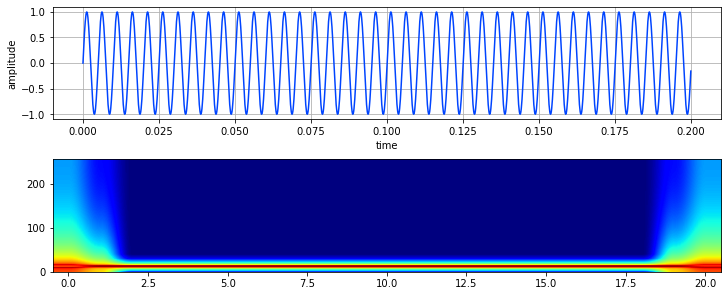

In [10]:
demo = WaveGenerator()

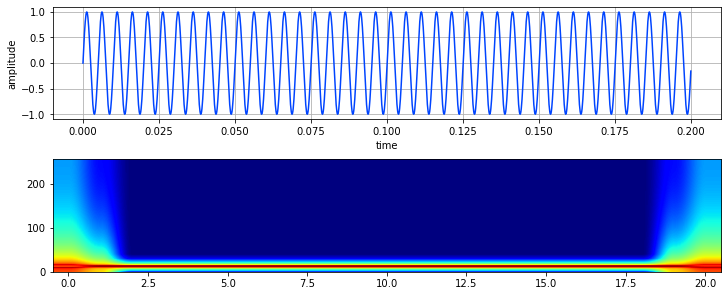

In [11]:
display(Audio(data=demo.y,rate=demo.samplerate))
display(demo.fig)

In [12]:
demo

WaveGenerator(children=(HBox(children=(VBox(children=(FloatSlider(value=200.0, continuous_update=False, descri…